# **先跑这**

In [1]:
from tensorflow import keras 
from tensorflow import keras as ks
import numpy as np
import pandas as pd
import sklearn as sk
import time
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import optimizers

from keras import backend as K
from keras import regularizers
from keras import initializers
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
## import data
X = np.load("/content/drive/MyDrive/HUDK_4050_Final/X.npy")
Y = np.load("/content/drive/MyDrive/HUDK_4050_Final/Y.npy")
X_test = np.load("/content/drive/MyDrive/HUDK_4050_Final/X_test.npy")
Y_test = np.load("/content/drive/MyDrive/HUDK_4050_Final/Y_test.npy")

print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)


(1649, 100, 100, 1)
(1649, 10)
(413, 100, 100, 1)
(413, 10)


Preprocess the data into right format

In [3]:
from keras.utils.np_utils import to_categorical
## unroll the height and width and thickness into one big vector
x_train = X.reshape(1649, 10000)
x_test = X_test.reshape(413, 10000)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

## normalize pixel values from 0 to 255
x_train /= 255
x_test /= 255

## 似乎不用这一步
# y_train = to_categorical(Y, 10)
# Y_test = to_categorical(Y_test, 10)
y_train = Y
y_test = Y_test

set up learning rate

In [4]:
import tensorflow
# Set up learning rate
## exponential Decay
initial_learning_rate = 0.1
exponential = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Piecewise Constant Decay ===> learning rate nan
step = tensorflow.Variable(0, trainable=False)
boundaries = [100000, 110000]
values = [1.0, 0.5, 0.1]
piecewise = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
# Later, whenever we perform an optimization step, we pass in the step.
# learning_rate = piecewise(step)

# Polynomial Decay ====> best performance
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 10000
polynomial = keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

## Build Neual Network Model

In [5]:
batch_size = 128
num_classes = 10
epochs = 5

In [6]:
model = Sequential()
model.add(Dense(4096, activation = "sigmoid", input_shape = (10000, )))
model.add(Dense(2048, activation = "sigmoid"))
model.add(Dense(512, activation = "sigmoid"))
model.add(Dense(64, activation = "sigmoid"))
model.add(Dense(num_classes, activation = "sigmoid"))

model.summary()

sgd = ks.optimizers.SGD(lr = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(loss = "categorical_crossentropy", 
              optimizer = sgd, metrics = "accuracy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              40964096  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,437,322
Trainable params: 50,437,322
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:
type(x_train)
type(y_train)

numpy.ndarray

Epoch 1/5
13/13 [==============================] - 11s 795ms/step - loss: 2.3661 - accuracy: 0.1007
Epoch 2/5
13/13 [==============================] - 10s 781ms/step - loss: 2.3610 - accuracy: 0.1007
Epoch 3/5
13/13 [==============================] - 10s 772ms/step - loss: 2.3552 - accuracy: 0.1001
Epoch 4/5
13/13 [==============================] - 11s 885ms/step - loss: 2.3495 - accuracy: 0.0958
Epoch 5/5
26/26 [==============================] - 3s 103ms/step - loss: 2.3396 - accuracy: 0.1114
Network test score [loss, accuracy]: [2.339589834213257, 0.11138014495372772]


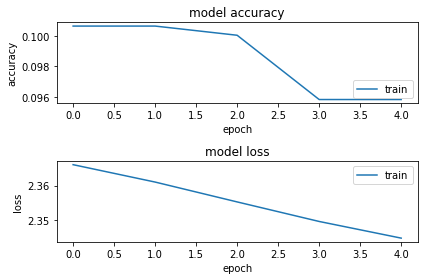

In [8]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          )

# plotting the metrics
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

score = model.evaluate(x_test, Y_test, batch_size=16)
print("Network test score [loss, accuracy]:", score)

## try tuner
最好的结果 0.55


In [9]:
# set hyper-parameters
batch_size = 128
num_classes = 10
epochs = 5

In [48]:
import math
try: 
  import keras_tuner
except: 
  !pip install keras-tuner --upgrade
finally: 
  import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    # model.add(layers.Flatten())
    # Tune the number of layers.
    # 原来是min = 16, max = 4096, step = 16
    model.add(Dense(units=hp.Int("1", min_value=16, max_value=4096, step=16),
                    activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
                    input_shape = (10000, ), 
                kernel_regularizer = regularizers.l2(0.001), 
                kernel_initializer=initializers.RandomNormal(mean=0, stddev = 1/math.sqrt(28))))
    for i in range(hp.Int("num_layers", 2, 10)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=4096, step=16),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
            )
        )
        #
        # model.add(layers.BatchNormalization())
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))
    #    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_classes, activation="softmax"))
    # normalize output
    # model.add(layers.BatchNormalization())
    learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=polynomial),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

In [44]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/drive/MyDrive/HUDK_4050_Final/",
    project_name="tuner",
)

search_result = tuner.search(x = x_train, y = y_train, epochs = 40, 
            
             batch_size = 128,
             validation_data = (x_test, y_test))

tuner.results_summary()

Trial 3 Complete [00h 14m 51s]
val_accuracy: 0.3615819215774536

Best val_accuracy So Far: 0.7288135488828024
Total elapsed time: 00h 44m 13s
Results summary
Results in /content/drive/MyDrive/HUDK_4050_Final/tuner
Showing 10 best trials
Trial summary
Hyperparameters:
1: 2976
activation: relu
num_layers: 2
units_0: 528
units_1: 1504
dropout: False
lr: 0.01978101759610635
Score: 0.7288135488828024
Trial summary
Hyperparameters:
1: 2176
activation: relu
num_layers: 5
units_0: 1472
units_1: 688
dropout: False
lr: 1.6997397224609708e-05
units_2: 944
units_3: 4048
units_4: 16
Score: 0.3615819215774536
Trial summary
Hyperparameters:
1: 1456
activation: relu
num_layers: 4
units_0: 3984
units_1: 1424
dropout: False
lr: 7.435257266599528e-05
units_2: 16
units_3: 16
Score: 0.35835350553194684


In [45]:
# Get the top 3 hyperparameters.
best_hps = tuner.get_best_hyperparameters(3)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_test))
# y_all = np.concatenate((y_train, y_test))
# history = model.fit(x=x_all, y=y_all, epochs=10)
history = model.fit(x = x_train, y = y_train, epochs = 10)

score = model.evaluate(x_test, y_test, batch_size=32)
print("Network test score [loss, accuracy]:", score)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Epoch 1/10
52/52 [==============================] - 14s 256ms/step - loss: 1053.6150 - accuracy: 0.5494
Epoch 2/10
52/52 [==============================] - 13s 257ms/step - loss: 1031.3456 - accuracy: 0.7580
Epoch 3/10
52/52 [==============================] - 13s 253ms/step - loss: 1010.0507 - accuracy: 0.8090
Epoch 4/10
52/52 [==============================] - 13s 250ms/step - loss: 989.3188 - accuracy: 0.8296
Epoch 5/10
52/52 [==============================] - 13s 254ms/step - loss: 969.0494 - accuracy: 0.8642
Epoch 6/10
52/52 [==============================] - 15s 282ms/step - loss: 949.2832 - accuracy: 0.8830
Epoch 7/10
52/52 [==============================] - 13s 251ms/step - loss: 929.9527 - accuracy: 0.9139
Epoch 8/10
52/52 [==============================] - 13s 253ms/step - loss: 911.1019 - accuracy: 0.9187
Epoch 9/10
52/52 [==============================] - 13s 252ms/step - loss: 892.6476 - accuracy: 0.9363
Epoch 10/10
13/13 [==============================] - 1s 96ms/step - lo

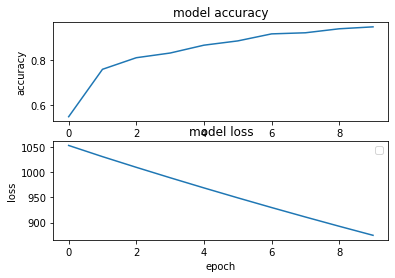

<Figure size 432x288 with 0 Axes>

In [46]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')


plt.subplot(2, 1, 2)
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.tight_layout()

## 1-10 neural


In [64]:
import math
try: 
  import keras_tuner
except: 
  !pip install keras-tuner --upgrade
finally: 
  import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    # model.add(layers.Flatten())
    # Tune the number of layers.

    model.add(Dense(units=hp.Int("1", min_value=1, max_value=128, step=1),
                    activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
                    input_shape = (10000, ), 
                kernel_regularizer = regularizers.l1(0.001), 
                kernel_initializer=initializers.RandomNormal(mean=0, stddev = 1/math.sqrt(10000))
                ))
    # model.add(layers.BatchNormalization())

    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=1, max_value=128, step=1),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
            )
        )
        #
        # model.add(layers.BatchNormalization())
    # if hp.Boolean("dropout"):
    #     model.add(layers.Dropout(rate=0.2))
    #    
    
    model.add(layers.Dense(num_classes, 
                           activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "softmax"])))
    # normalize output
    # model.add(layers.BatchNormalization())
    learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

In [65]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/drive/MyDrive/HUDK_4050_Final/",
    project_name="tuner_small",
)

search_result = tuner.search(x = x_train, y = y_train, epochs = 100, 
            
             batch_size = 128,
             validation_data = (x_test, y_test))

tuner.results_summary()

Trial 3 Complete [00h 02m 05s]
val_accuracy: 0.11380145450433095

Best val_accuracy So Far: 0.11380145450433095
Total elapsed time: 00h 06m 16s
Results summary
Results in /content/drive/MyDrive/HUDK_4050_Final/tuner_small
Showing 10 best trials
Trial summary
Hyperparameters:
1: 92
activation: sigmoid
num_layers: 3
units_0: 15
units_1: 1
lr: 3.38442322558317e-05
units_2: 126
Score: 0.11380145450433095
Trial summary
Hyperparameters:
1: 111
activation: relu
num_layers: 2
units_0: 71
units_1: 107
lr: 2.1124437102323893e-06
Score: 0.0944309930006663
Trial summary
Hyperparameters:
1: 42
activation: sigmoid
num_layers: 3
units_0: 108
units_1: 111
lr: 2.3488862668247706e-08
units_2: 1
Score: 0.09281678994496663


In [61]:
# Get the top 3 hyperparameters.
best_hps = tuner.get_best_hyperparameters(3)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_test))
# y_all = np.concatenate((y_train, y_test))
# history = model.fit(x=x_all, y=y_all, epochs=10)
# history = model.fit(x = x_train, y = y_train, epochs = 100)

score = model.evaluate(x_test, y_test, batch_size=32)
print("Network test score [loss, accuracy]:", score)



13/13 [==============================] - 0s 6ms/step - loss: 9.9276 - accuracy: 0.1211
Network test score [loss, accuracy]: [9.927610397338867, 0.12106537818908691]
